In [1]:
using Distributions
using HypothesisTests
using QuadGK
using Random
using Roots
using StatsPlots
default(fmt=:png, legendfontsize=11)

distname(dist) = replace(string(dist),
    r"{[^}]*}"=>"",
    r".="=>"",
    "Binomial"=>"Bin"
)

_ecdf(A, x) = count(≤(x), A) / length(A)

safediv(x, y) = x == 0 ? zero(x/y) : x/y

function pvalue_chisq(a, b, c, d; yates=false)
    N = a+b+c+d
    chisqstat = safediv(N*max(0, abs(a*d - b*c) - (N/2)yates)^2, (a+b)*(c+d)*(a+c)*(b+d))
    ccdf(Chisq(1), chisqstat)
end

function pvals(randabcd; niters=10^5)
    pval_chisq = zeros(niters)
    pval_yates = zeros(niters)
    pval_minlike = zeros(niters)
    pval_central = zeros(niters)
    Threads.@threads :static for i in 1:niters
        a, b, c, d = randabcd()
        pval_chisq[i] = pvalue_chisq(a, b, c, d)
        pval_yates[i] = pvalue_chisq(a, b, c, d; yates=true)
        fet = FisherExactTest(a, b, c, d)
        pval_minlike[i] = pvalue(fet; method=:minlike)
        pval_central[i] = pvalue(fet)
    end
    (; pval_chisq, pval_yates, pval_minlike, pval_central)
end

function make_randabcd(bin1::Binomial, bin2::Binomial)
    function randabcd_2binomials()
        a, c = rand(bin1), rand(bin2)
        b, d = ntrials(bin1)-a, ntrials(bin2)-c
        a, b, c, d
    end
    randabcd_2binomials
end

function plot_pvals(; bin1=Binomial(12, 0.25), bin2=Binomial(16, 0.25), niters=10^6)
    m, p = params(bin1)
    n, q = params(bin2)
    ytick = p == q ? (0:0.01:1) : (0:0.05:1)
    legend = p == q ? true : (:bottomright)
    yguide = "probability of P-value ≤ α"
    yguide *= p == q ? "  (α-error rate)" : "  (power)"
    
    println("true expectation value: ")
    Base.print_array(stdout, round.([m*p m*(1-p); n*q n*(1-q)]; sigdigits=3))
    println("\n")
    
    randabcd_2binomials = make_randabcd(bin1, bin2)
    (; pval_chisq, pval_yates, pval_minlike, pval_central) = pvals(randabcd_2binomials; niters)
    
    print("probability of P-value ≤ 5%")
    println(p == q ? "  (α-error rate)" : "  (power)")
    println("  χ²-test:               ", round(100_ecdf(pval_chisq, 0.05); digits=1), "%")
    println("  Fisher test (minlike): ", round(100_ecdf(pval_minlike, 0.05); digits=1), "%")
    println("  χ²-test (Yates):       ", round(100_ecdf(pval_yates, 0.05); digits=1), "%")
    println("  Fisher test (central): ", round(100_ecdf(pval_central, 0.05); digits=1), "%")
    println()
    
    plot(α -> _ecdf(pval_chisq, α), 0, 0.1; label="χ²-test")
    plot!(α -> _ecdf(pval_minlike, α), 0, 0.1; label="Fisher test (minlike)", ls=:dash)
    plot!(α -> _ecdf(pval_yates, α), 0, 0.1; label="χ²-test (Yates)", ls=:dot)
    plot!(α -> _ecdf(pval_central, α), 0, 0.1; label="Fisher test (central)", ls=:dashdot)
    p == q && plot!(identity; label="", ls=:dot, c=:black, alpha=0.5)
    plot!(; legend)
    plot!(; xtick=0:0.01:1, ytick, xrotation=90)
    plot!(; xguide="α", yguide)
    title!("model: $(distname(bin1))×$(distname(bin2))", titlefontsize=12)
    plot!(size=(500, 500))
end

function plot_powers(; )
    
end

plot_powers (generic function with 1 method)

true expectation value: 
 1.5  4.5
 2.0  6.0

probability of P-value ≤ 5%  (α-error rate)
  χ²-test:               5.0%
  Fisher test (minlike): 1.0%
  χ²-test (Yates):       0.6%
  Fisher test (central): 0.6%



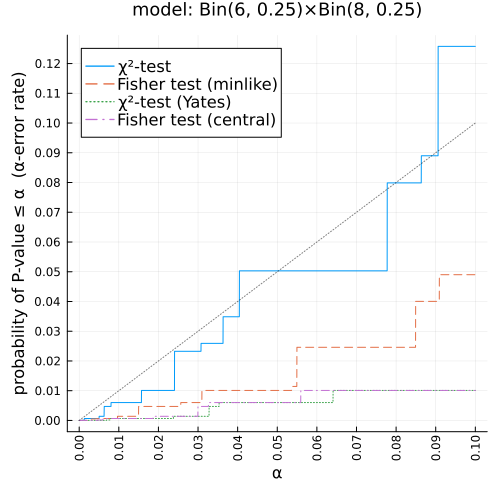

In [2]:
plot_pvals(; bin1=Binomial(6, 0.25), bin2=Binomial(8, 0.25))

true expectation value: 
 1.5   4.5
 7.12  0.88

probability of P-value ≤ 5%  (power)
  χ²-test:               80.0%
  Fisher test (minlike): 57.2%
  χ²-test (Yates):       56.4%
  Fisher test (central): 56.4%



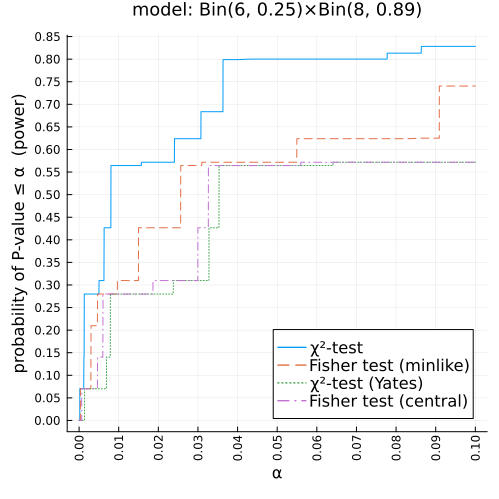

In [3]:
plot_pvals(; bin1=Binomial(6, 0.25), bin2=Binomial(8, 0.89))

true expectation value: 
 3.0   9.0
 4.0  12.0

probability of P-value ≤ 5%  (α-error rate)
  χ²-test:               5.0%
  Fisher test (minlike): 2.7%
  χ²-test (Yates):       1.1%
  Fisher test (central): 1.9%



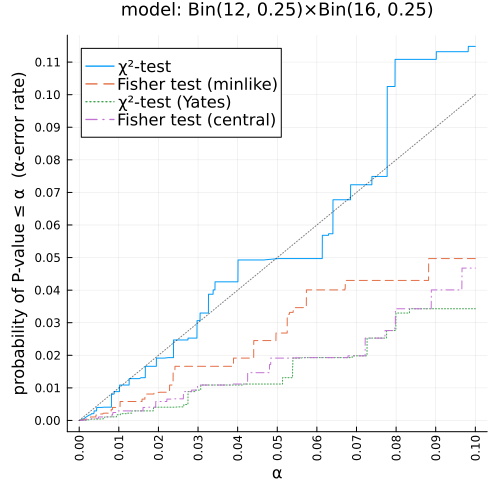

In [4]:
plot_pvals(; bin1=Binomial(12, 0.25), bin2=Binomial(16, 0.25))

true expectation value: 
  3.0  9.0
 12.1  3.92

probability of P-value ≤ 5%  (power)
  χ²-test:               80.3%
  Fisher test (minlike): 67.4%
  χ²-test (Yates):       64.4%
  Fisher test (central): 64.6%



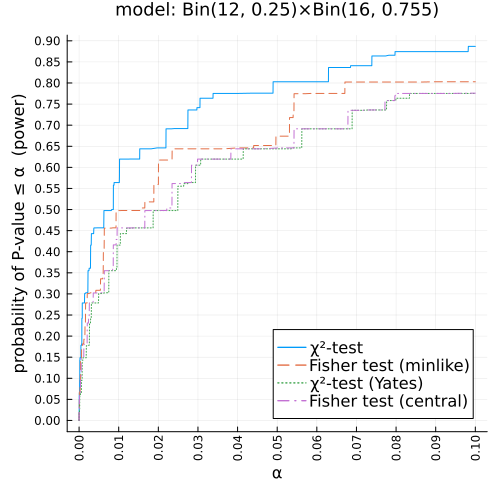

In [5]:
plot_pvals(; bin1=Binomial(12, 0.25), bin2=Binomial(16, 0.755))

true expectation value: 
 6.0  18.0
 8.0  24.0

probability of P-value ≤ 5%  (α-error rate)
  χ²-test:               4.6%
  Fisher test (minlike): 3.2%
  χ²-test (Yates):       2.2%
  Fisher test (central): 2.2%



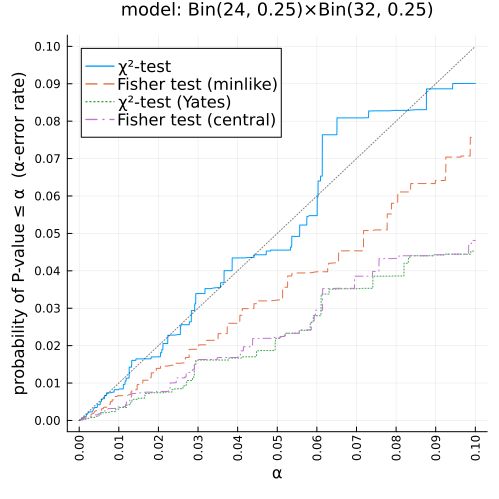

In [6]:
plot_pvals(; bin1=Binomial(24, 0.25), bin2=Binomial(32, 0.25))

true expectation value: 
  6.0  18.0
 19.7  12.3

probability of P-value ≤ 5%  (power)
  χ²-test:               79.9%
  Fisher test (minlike): 72.8%
  χ²-test (Yates):       71.5%
  Fisher test (central): 72.5%



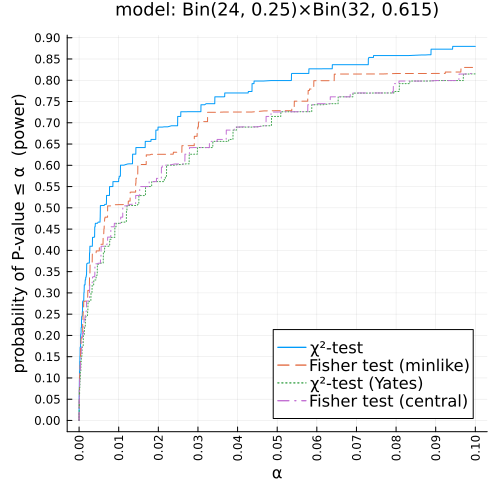

In [7]:
plot_pvals(; bin1=Binomial(24, 0.25), bin2=Binomial(32, 0.615))

true expectation value: 
 30.0   90.0
 40.0  120.0

probability of P-value ≤ 5%  (α-error rate)
  χ²-test:               5.0%
  Fisher test (minlike): 4.3%
  χ²-test (Yates):       3.6%
  Fisher test (central): 3.5%



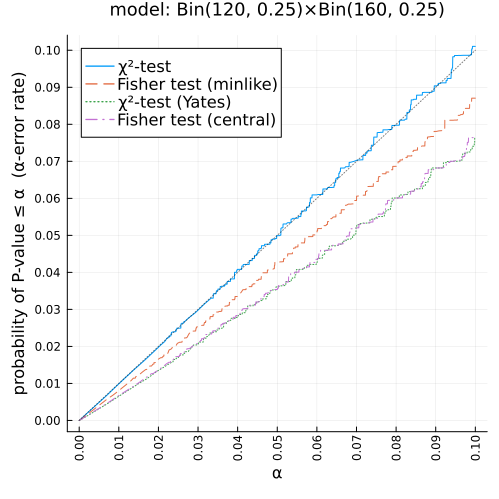

In [8]:
plot_pvals(; bin1=Binomial(120, 0.25), bin2=Binomial(160, 0.25))

true expectation value: 
 30.0  90.0
 65.6  94.4

probability of P-value ≤ 5%  (power)
  χ²-test:               80.7%
  Fisher test (minlike): 79.3%
  χ²-test (Yates):       76.9%
  Fisher test (central): 77.2%



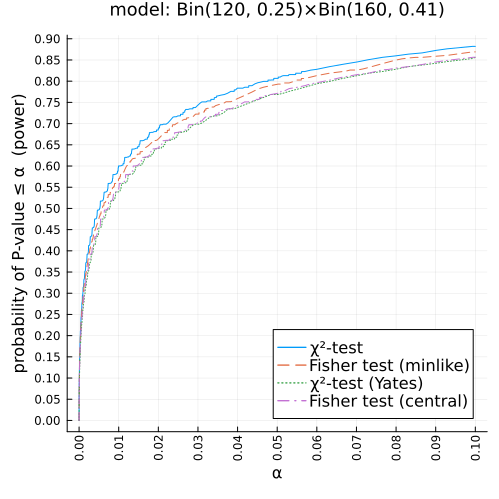

In [9]:
plot_pvals(; bin1=Binomial(120, 0.25), bin2=Binomial(160, 0.41))

true expectation value: 
 3.0  117.0
 4.0  156.0

probability of P-value ≤ 5%  (α-error rate)
  χ²-test:               4.4%
  Fisher test (minlike): 3.1%
  χ²-test (Yates):       1.1%
  Fisher test (central): 1.4%



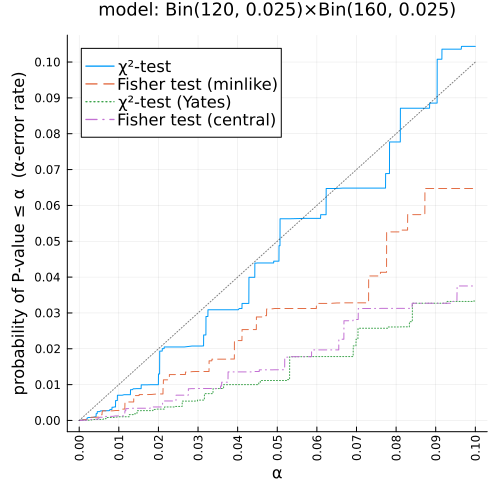

In [10]:
plot_pvals(; bin1=Binomial(120, 0.025), bin2=Binomial(160, 0.025))

true expectation value: 
  3.0  117.0
 16.8  143.0

probability of P-value ≤ 5%  (power)
  χ²-test:               80.1%
  Fisher test (minlike): 75.4%
  χ²-test (Yates):       68.0%
  Fisher test (central): 71.6%



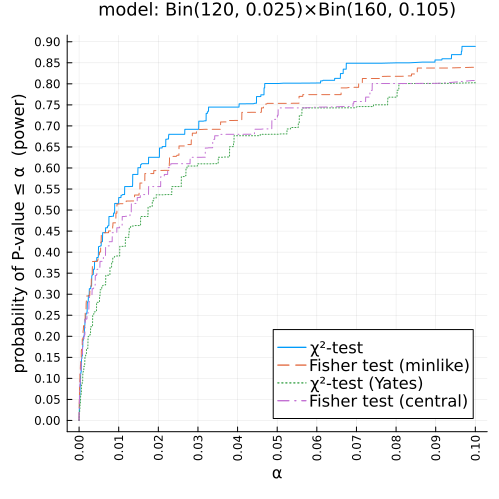

In [11]:
plot_pvals(; bin1=Binomial(120, 0.025), bin2=Binomial(160, 0.105))